In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch

from symplearn.datasets import VectorFieldDataset, SnapshotDataset
from symplearn.training import EulerDVINewtonLoss
from symplearn.training.norms import GramMSNorm

from utils import init_env

In [2]:
pb, models = init_env()
norm = GramMSNorm()

data_vf = VectorFieldDataset("val")
data_dvi = SnapshotDataset("val")
dt = data_dvi.dt

In [3]:
z_vf, t_vf, dt_z_vf = data_vf[:]

dt_z_vf_reg = torch.vmap(models["vf_reg"].vector_field)(z_vf, t_vf)
err_vf_reg = dt_z_vf_reg - dt_z_vf

dt_z_vf_no_reg = torch.vmap(models["vf_no_reg"].vector_field)(z_vf, t_vf)
err_vf_no_reg = dt_z_vf_no_reg - dt_z_vf

In [4]:
dl_dvi = torch.utils.data.DataLoader(data_dvi, batch_size=len(data_dvi))
z0_sch, z1_sch, z2_sch, dt_sch = next(iter(dl_dvi))

loss_dvi = EulerDVINewtonLoss(models["dvi"], float(dt_sch[0]))
jac_dvi, dvi = torch.vmap(loss_dvi.dvi_with_jacobian)(z0_sch, z1_sch, z2_sch, dt_sch)
err_dvi = torch.linalg.solve(jac_dvi, dvi)

In [5]:
def compute_err(err, scaler):
    sqrt_inv_gram_mat = norm.build_gram_mat(scaler)
    return torch.square(err @ sqrt_inv_gram_mat).sum(-1).sqrt()

norm_err_vf_reg = compute_err(err_vf_reg, dt_z_vf)
norm_err_vf_no_reg = compute_err(err_vf_no_reg, dt_z_vf)
norm_err_dvi = compute_err(err_dvi, (z2_sch - z1_sch) / dt_sch[:, None])

In [6]:
err_min = min(norm_err_vf_reg.min(), norm_err_vf_no_reg.min(), norm_err_dvi.min())
err_max = max(norm_err_vf_reg.max(), norm_err_vf_no_reg.max(), norm_err_dvi.max())
cnorm = mpl.colors.LogNorm(err_min, err_max)


def plot_err(ax, z, err):
    err = err.detach().numpy()
    sc = ax.scatter(*z.T, s=8, c=err, norm=cnorm, cmap="viridis")
    ax.set(xlabel="x", ylabel="y")
    return sc

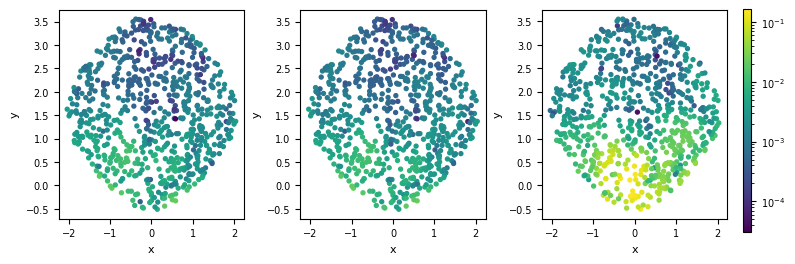

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))

plot_err(ax1, z_vf, norm_err_vf_reg)
plot_err(ax2, z_vf, norm_err_vf_no_reg)
p = plot_err(ax3, z1_sch, norm_err_dvi)

fig.tight_layout(pad=0.2, w_pad=1.0)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.89])
fig.colorbar(p, cax=cbar_ax)

fig.savefig(os.path.join("figures", "errors.pdf"), bbox_inches="tight")